<a href="https://colab.research.google.com/github/nantmoe-theingi/airbnb-nz-deception-sentiment/blob/main/notebooks/04_distilBERT_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
PROJECT_DRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment"

from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs(PROJECT_DRIVE_DIR, exist_ok=True)
print("Drive project folder:", PROJECT_DRIVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive project folder: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [3]:
cd {PROJECT_DRIVE_DIR}

/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment


In [17]:
# DistilBERT Sentiment Fine-tuning (3-class)

import os, itertools, joblib
from pathlib import Path

import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support
)
from sklearn.utils.class_weight import compute_class_weight

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, set_seed
)

In [18]:
# 0) Config & seeding
MODEL_NAME = "distilbert-base-uncased"
ROOT_DIR = Path("artifacts/distilbert_sentiment_sweep")
ROOT_DIR.mkdir(parents=True, exist_ok=True)
set_seed(42)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [40]:
# 1) Load data (expects columns: "text", "label")
#    If labels are strings, map to ints here.
df = pd.read_csv("data/tripadvisor_prepared_3class.csv")
print(df.head())

                                                text sentiment  y
0  nice hotel expensive parking got good deal sta...  positive  2
1  ok nothing special charge diamond member hilto...  negative  0
2  nice rooms not 4* experience hotel monaco seat...   neutral  1
3  unique, great stay, wonderful time hotel monac...  positive  2
4  great stay great stay, went seahawk game aweso...  positive  2


In [41]:
# Rename column 'y' to 'label'
df = df.rename(columns={"y": "label"})

# verify the change
print(df.head())

                                                text sentiment  label
0  nice hotel expensive parking got good deal sta...  positive      2
1  ok nothing special charge diamond member hilto...  negative      0
2  nice rooms not 4* experience hotel monaco seat...   neutral      1
3  unique, great stay, wonderful time hotel monac...  positive      2
4  great stay great stay, went seahawk game aweso...  positive      2


In [42]:
df = df.dropna(subset=["text", "label"]).copy()
print(df.head())

                                                text sentiment  label
0  nice hotel expensive parking got good deal sta...  positive      2
1  ok nothing special charge diamond member hilto...  negative      0
2  nice rooms not 4* experience hotel monaco seat...   neutral      1
3  unique, great stay, wonderful time hotel monac...  positive      2
4  great stay great stay, went seahawk game aweso...  positive      2


In [43]:
# 2) Stratified 70/15/15 split
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=42
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 14331 | Val: 3071 | Test: 3071


In [44]:
# 3) Tokenizer + datasets
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256,
    )

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds   = Dataset.from_pandas(val_df).map(tokenize, batched=True)
test_ds  = Dataset.from_pandas(test_df).map(tokenize, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format("torch", columns=cols)
val_ds.set_format("torch", columns=cols)
test_ds.set_format("torch", columns=cols)

Map:   0%|          | 0/14331 [00:00<?, ? examples/s]

Map:   0%|          | 0/3071 [00:00<?, ? examples/s]

Map:   0%|          | 0/3071 [00:00<?, ? examples/s]

In [45]:
# 4) Metrics (macro-averaged)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    # Optional: weighted for reference
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(
        labels, preds, average="weighted", zero_division=0
    )
    return {
        "accuracy": acc,
        "macro_precision": p_macro,
        "macro_recall": r_macro,
        "macro_f1": f1_macro,
        "weighted_f1": f1_w,
    }

In [46]:
# 5) Class weights (from data) and weighted loss
import torch.nn as nn

num_labels = 3
classes = np.array(sorted(df["label"].unique()))
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["label"].values
)
# Ensure tensor on correct device later
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)


class WeightedTrainer(Trainer):
    # NOTE: accept num_items_in_batch and **kwargs for forward-compatibility
    def compute_loss(
        self,
        model,
        inputs,
        return_outputs=False,
        num_items_in_batch: int | None = None,   # HF >= 4.41+
        **kwargs,                                # future args-safe
    ):
        # HF datasets usually use "labels"; fall back to "label" just in case
        labels = inputs.pop("labels", None)
        if labels is None and "label" in inputs:
            labels = inputs.pop("label")

        outputs = model(**inputs)
        logits = outputs.get("logits", outputs[0])

        # class_weights_tensor defined earlier; ensure correct device/dtype
        weights = class_weights_tensor.to(logits.device).type_as(logits)

        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


def new_model():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id
    )

In [47]:
# 6) Small, meaningful sweep
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
grid = {
    "num_train_epochs": [2, 3, 4],
    "learning_rate": [1e-5, 2e-5, 3e-5],
    "lr_scheduler_type": ["linear", "cosine"],
    "warmup_ratio": [0.0, 0.06],
}

results = []

for epochs, lr, sched, warm in itertools.product(
    grid["num_train_epochs"], grid["learning_rate"],
    grid["lr_scheduler_type"], grid["warmup_ratio"]
):
    run_name = f"e{epochs}_lr{lr}_sch-{sched}_warm{warm}"
    out_dir = ROOT_DIR / "runs" / run_name
    out_dir.mkdir(parents=True, exist_ok=True)

    model = new_model()

    args = TrainingArguments(
        output_dir=str(out_dir),
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=lr,
        num_train_epochs=epochs,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",   # select by macro-F1
        greater_is_better=True,
        lr_scheduler_type=sched,
        warmup_ratio=warm,
        logging_steps=100,
        save_total_limit=1,
        report_to=[],                      # no wandb
        seed=42,
        fp16=False,
    )

    trainer = WeightedTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    val_metrics = trainer.evaluate()
    results.append({
        "run": run_name,
        "epochs": epochs,
        "lr": lr,
        "scheduler": sched,
        "warmup": warm,
        **{k: round(val_metrics[k], 4) for k in (
            "eval_accuracy", "eval_macro_precision",
            "eval_macro_recall", "eval_macro_f1", "eval_weighted_f1"
        )}
    })

    # free memory between runs
    del trainer, model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.648300,0.643659,0.869749,0.736536,0.729779,0.733100,0.868830
2,0.563700,0.618898,0.859004,0.728488,0.754669,0.738938,0.866129


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.638000,0.608404,0.871703,0.741259,0.748857,0.744933,0.873164
2,0.548000,0.606570,0.862260,0.734885,0.760719,0.745203,0.869031


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.636300,0.607038,0.870075,0.742544,0.750087,0.745897,0.872487
2,0.557100,0.626853,0.860632,0.730222,0.758016,0.741789,0.867381


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.643600,0.613385,0.871052,0.738825,0.743442,0.741072,0.872090
2,0.544000,0.618619,0.862585,0.730562,0.759772,0.743113,0.868796


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.673700,0.608098,0.865842,0.726757,0.746749,0.736115,0.869291
2,0.556200,0.653780,0.861283,0.726858,0.752973,0.737918,0.867627


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.682300,0.613187,0.871377,0.738491,0.753719,0.745813,0.873372
2,0.559500,0.652710,0.863562,0.731997,0.758693,0.743252,0.869746


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.668500,0.599824,0.867796,0.736063,0.752216,0.743325,0.871555
2,0.574200,0.668634,0.862585,0.730058,0.756500,0.741433,0.868647


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.673900,0.617329,0.874959,0.743248,0.756317,0.749515,0.875701
2,0.559500,0.657642,0.864865,0.733137,0.758954,0.744248,0.870553


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.667900,0.612145,0.868772,0.743553,0.751799,0.746107,0.872861
2,0.586600,0.656945,0.869424,0.742025,0.765705,0.751792,0.875212


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.708900,0.594078,0.868772,0.742383,0.758329,0.748679,0.873765
2,0.544800,0.652714,0.865516,0.740885,0.763943,0.749111,0.872674


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.665000,0.629270,0.864865,0.729841,0.753290,0.740307,0.869648
2,0.556800,0.682739,0.865190,0.734288,0.761174,0.745576,0.871383


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.677600,0.628449,0.867144,0.734356,0.749738,0.741541,0.870162
2,0.536200,0.647202,0.869098,0.744408,0.765886,0.753280,0.874363


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.657300,0.600505,0.866167,0.733001,0.745808,0.738977,0.869001
2,0.573800,0.634655,0.864214,0.742733,0.759977,0.748441,0.870512
3,0.674100,0.752880,0.863888,0.734469,0.753280,0.742555,0.868723


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.648700,0.615526,0.875936,0.749276,0.752845,0.751029,0.876629
2,0.566000,0.639888,0.868447,0.745281,0.752740,0.747273,0.872738
3,0.648200,0.750286,0.868121,0.736796,0.758133,0.746438,0.872421


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.674200,0.612343,0.871703,0.742983,0.754634,0.748542,0.873783
2,0.570100,0.646092,0.866493,0.742370,0.753705,0.746267,0.871291
3,0.589600,0.712219,0.861934,0.727728,0.755333,0.739895,0.867575


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.665500,0.625650,0.876587,0.752965,0.747042,0.749956,0.876189
2,0.569300,0.644008,0.868447,0.745065,0.751868,0.746718,0.872753
3,0.588300,0.724134,0.865842,0.734313,0.764078,0.747226,0.871804


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.710400,0.595696,0.869098,0.747007,0.759027,0.751180,0.873682
2,0.610900,0.645316,0.870075,0.753428,0.760781,0.754635,0.874802
3,0.617500,0.797994,0.869424,0.741687,0.758729,0.748895,0.874015


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.713600,0.621717,0.866819,0.727530,0.744136,0.735482,0.868504
2,0.582600,0.689618,0.876262,0.754267,0.740797,0.747217,0.875688
3,0.543000,0.823706,0.871377,0.743104,0.756125,0.749023,0.874402


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.691000,0.620444,0.870401,0.740547,0.755900,0.747804,0.872984
2,0.601500,0.658801,0.876262,0.756502,0.760303,0.757713,0.878619
3,0.533200,0.786277,0.871377,0.740393,0.764078,0.751022,0.875895


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.708600,0.623883,0.863237,0.720259,0.743387,0.731134,0.866229
2,0.582800,0.668281,0.873657,0.744844,0.746916,0.745722,0.874886
3,0.437200,0.786339,0.869098,0.735925,0.756071,0.745103,0.873130


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.727500,0.642607,0.870726,0.738985,0.756152,0.747110,0.873449
2,0.595600,0.639250,0.876913,0.755881,0.759942,0.757514,0.878757
3,0.554600,0.800705,0.880169,0.761153,0.769473,0.765137,0.881636


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.703200,0.585804,0.859980,0.727047,0.760232,0.740923,0.867126
2,0.573700,0.683446,0.869749,0.742784,0.756700,0.748805,0.873425
3,0.484800,0.841496,0.871703,0.745651,0.763682,0.753718,0.875514


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.740400,0.627994,0.868772,0.745627,0.752992,0.748445,0.871790
2,0.631300,0.607439,0.868772,0.742174,0.774013,0.755954,0.874600
3,0.530600,0.767148,0.876262,0.755773,0.772393,0.762963,0.880080


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.727000,0.583796,0.859655,0.728211,0.758780,0.740654,0.866905
2,0.600200,0.666844,0.877890,0.757856,0.764416,0.760658,0.880014
3,0.488500,0.803967,0.875285,0.753396,0.769230,0.759912,0.879536


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.674400,0.614150,0.871377,0.741957,0.753398,0.747441,0.873329
2,0.575700,0.657063,0.868121,0.751081,0.746607,0.746393,0.871870
3,0.631000,0.797335,0.867796,0.735745,0.750249,0.742563,0.870580
4,0.398400,0.842249,0.863562,0.728786,0.756287,0.741113,0.868738


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.674100,0.629605,0.869098,0.733477,0.743319,0.738280,0.870218
2,0.604000,0.642026,0.870401,0.748119,0.744576,0.745868,0.871742
3,0.608900,0.780167,0.868447,0.734620,0.752065,0.742942,0.870868
4,0.412000,0.827510,0.866493,0.731852,0.761534,0.745282,0.871436


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.670400,0.616580,0.864539,0.725943,0.742672,0.733937,0.866922
2,0.579100,0.627843,0.869098,0.748284,0.755107,0.749933,0.873171
3,0.654900,0.752312,0.865842,0.735834,0.766910,0.749208,0.872040
4,0.409600,0.801875,0.868121,0.737695,0.760861,0.747958,0.872913


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.685700,0.627121,0.868772,0.732928,0.749380,0.740825,0.870698
2,0.608900,0.643530,0.871703,0.751997,0.747238,0.748979,0.873142
3,0.620100,0.764003,0.869098,0.740063,0.766640,0.751944,0.873922
4,0.413800,0.807310,0.868121,0.736299,0.762382,0.748151,0.872618


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.690000,0.617726,0.867144,0.731981,0.755187,0.742654,0.871206
2,0.598800,0.734818,0.873982,0.752745,0.721578,0.735956,0.871297
3,0.511400,0.838302,0.862260,0.725726,0.758962,0.740625,0.867763
4,0.254300,0.952379,0.867144,0.737204,0.758137,0.746067,0.872288


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.726900,0.652056,0.868121,0.726968,0.739054,0.732244,0.867595
2,0.597800,0.698070,0.871052,0.746072,0.733430,0.739363,0.870838
3,0.558900,0.886985,0.872029,0.734953,0.752591,0.743356,0.873443
4,0.364500,0.998615,0.873657,0.744136,0.766303,0.754345,0.877423


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.690000,0.616045,0.866819,0.731972,0.749696,0.740345,0.869733
2,0.625100,0.694351,0.868772,0.744949,0.727829,0.735252,0.869341
3,0.494600,0.864284,0.862585,0.727643,0.754212,0.739389,0.868089
4,0.287300,0.956253,0.867144,0.735745,0.754754,0.744195,0.871459


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.714000,0.659639,0.869749,0.728057,0.746544,0.736306,0.870025
2,0.572800,0.684708,0.872029,0.751571,0.737688,0.743884,0.872468
3,0.494300,0.873718,0.872680,0.741658,0.751155,0.746176,0.874644
4,0.355000,0.970977,0.871052,0.741976,0.761971,0.750854,0.875339


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.726900,0.629943,0.857375,0.712835,0.754785,0.731474,0.862986
2,0.610000,0.686660,0.874959,0.761818,0.734883,0.746691,0.874355
3,0.489900,0.888816,0.874308,0.738733,0.747080,0.742001,0.872940
4,0.322900,1.003650,0.871377,0.743008,0.758630,0.750340,0.874114


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.746700,0.574869,0.851189,0.725805,0.764435,0.738468,0.862662
2,0.601300,0.705362,0.876262,0.761371,0.749084,0.754417,0.876962
3,0.522300,0.890941,0.875936,0.744170,0.743791,0.743684,0.874465
4,0.206800,1.036583,0.873982,0.746282,0.766018,0.755217,0.877855


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.731800,0.610705,0.859980,0.725003,0.771332,0.744880,0.867402
2,0.579800,0.718885,0.879518,0.762773,0.740743,0.751213,0.877082
3,0.548800,0.799360,0.875936,0.745563,0.767328,0.755897,0.878129
4,0.292800,0.946165,0.879844,0.757956,0.773358,0.764998,0.882799


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-383261731.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.739900,0.566571,0.845327,0.720853,0.765487,0.734561,0.859098
2,0.557600,0.654600,0.872029,0.749757,0.745752,0.746905,0.873924
3,0.513300,0.862384,0.877890,0.749327,0.749802,0.749540,0.877547
4,0.253100,1.002398,0.874308,0.744243,0.755596,0.749551,0.876769


In [48]:
# 7) Pick best by macro-F1 and retrain once
res_df = pd.DataFrame(results).sort_values("eval_macro_f1", ascending=False)
res_df.to_csv(ROOT_DIR / "sweep_results_sentiment.csv", index=False)
best = res_df.iloc[0]
print("Best config:\n", best.to_dict())

FINAL_DIR = ROOT_DIR / "best_model"
FINAL_DIR.mkdir(parents=True, exist_ok=True)

best_args = TrainingArguments(
    output_dir=str(FINAL_DIR),
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=float(best["lr"]),
    num_train_epochs=int(best["epochs"]),
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    lr_scheduler_type=best["scheduler"],
    warmup_ratio=float(best["warmup"]),
    logging_steps=100,
    save_total_limit=1,
    report_to=[],
    seed=42,
    fp16=False,
)

model = new_model()
trainer = WeightedTrainer(
    model=model,
    args=best_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
print("\nValidation (best run):", trainer.evaluate())

Best config:
 {'run': 'e3_lr3e-05_sch-linear_warm0.0', 'epochs': 3, 'lr': 3e-05, 'scheduler': 'linear', 'warmup': 0.0, 'eval_accuracy': 0.8802, 'eval_macro_precision': 0.7612, 'eval_macro_recall': 0.7695, 'eval_macro_f1': 0.7651, 'eval_weighted_f1': 0.8816}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1669826983.py:32: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.733400,0.578547,0.858027,0.738041,0.760560,0.744025,0.867067


Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted F1
1,0.733400,0.578547,0.858027,0.738041,0.760560,0.744025,0.867067
2,0.579300,0.644733,0.873331,0.751419,0.752767,0.751202,0.875915
3,0.513100,0.823133,0.875936,0.751794,0.760149,0.755590,0.878159



Validation (best run): {'eval_loss': 0.8231328725814819, 'eval_accuracy': 0.8759361771409964, 'eval_macro_precision': 0.7517936440425953, 'eval_macro_recall': 0.7601488272555913, 'eval_macro_f1': 0.7555896341565437, 'eval_weighted_f1': 0.8781594251082689, 'eval_runtime': 23.4119, 'eval_samples_per_second': 131.172, 'eval_steps_per_second': 16.402, 'epoch': 3.0}


In [49]:
# 8) Final test evaluation
test_metrics = trainer.evaluate(test_ds)
print("\nTest metrics:", test_metrics)


Test metrics: {'eval_loss': 0.9721450209617615, 'eval_accuracy': 0.8661673721914686, 'eval_macro_precision': 0.7383556241840465, 'eval_macro_recall': 0.7272764936768302, 'eval_macro_f1': 0.7326130051579872, 'eval_weighted_f1': 0.8656708699466312, 'eval_runtime': 24.824, 'eval_samples_per_second': 123.711, 'eval_steps_per_second': 15.469, 'epoch': 3.0}


In [50]:
# 9) Save artifacts
trainer.save_model(FINAL_DIR)          # model + config
tokenizer.save_pretrained(FINAL_DIR)   # tokenizer files
joblib.dump(id2label, FINAL_DIR / "label_map.joblib")
print("\nSaved to:", FINAL_DIR.resolve())


Saved to: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment/artifacts/distilbert_sentiment_sweep/best_model


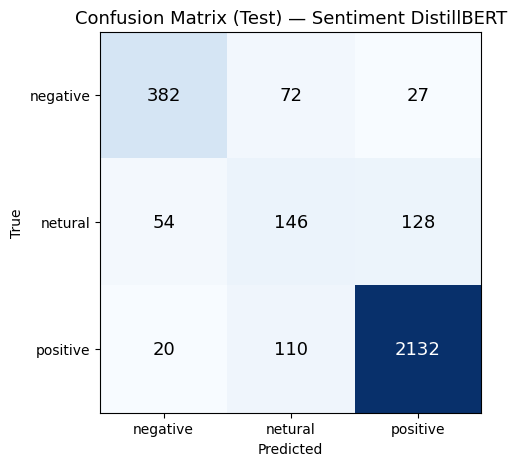

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and labels
preds_output = trainer.predict(test_ds)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "netural", "positive"])

plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (Test) — Sentiment DistillBERT", fontsize=13)
plt.xticks([0, 1, 2], ["negative", "netural", "positive"])
plt.yticks([0, 1, 2], ["negative", "netural", "positive"])
plt.xlabel("Predicted")
plt.ylabel("True")

for (i, j), v in np.ndenumerate(cm):
    color = "white" if v > cm.max() / 2 else "black"
    plt.text(j, i, str(v), ha="center", va="center", color=color, fontsize=13)

plt.tight_layout()

# === SAVE TO FILE ===
plt.savefig("figures/confusion_matrix_distilbert_sentiment.png", dpi=300, bbox_inches="tight")
plt.show()

In [57]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Compute metrics from test predictions

row_test = {
    "Model": "DistilBERT (Fine-tuned, test))",
    "Accuracy": round(accuracy_score(y_true, y_pred), 2),
    "Macro-F1": round(f1_score(y_true, y_pred, average="macro"), 2),
    "Precision": round(precision_score(y_true, y_pred, average="macro"), 2),
    "Recall": round(recall_score(y_true, y_pred, average="macro"), 2)
}

# Create dataframe or append to file
try:
    df_test = pd.read_csv("figures/model_comparison_sentiment.csv")
except FileNotFoundError:
    df_test = pd.DataFrame(columns=["Model", "Accuracy", "Macro-F1", "Precision", "Recall"])

df_test = pd.concat([df_test, pd.DataFrame([row_test])], ignore_index=True)

# Save updated comparison table
df_test.to_csv("figures/model_comparison_sentiment.csv", index=False)
print("Added DistilBERT results to model_comparison_sentiment.csv")
print(df_test)

Added DistilBERT results to model_comparison_sentiment.csv
                            Model  Accuracy  Macro-F1  Precision  Recall
0                    SVM (TF–IDF)      0.87      0.70       0.73    0.69
1  DistilBERT (Fine-tuned, test))      0.87      0.73       0.74    0.73


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


<Figure size 500x500 with 0 Axes>

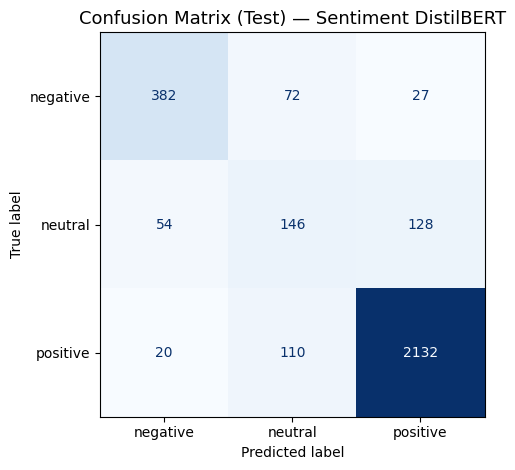

<Figure size 500x500 with 0 Axes>

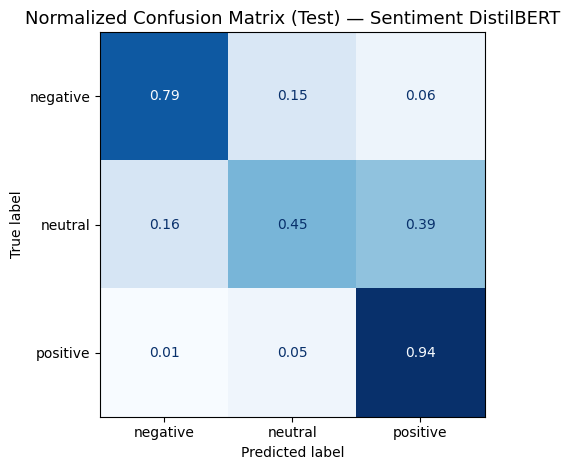

Confusion matrices saved to:
  → Figures/confusion_matrix_distilbert_sentiment.png
  → Figures/confusion_matrix_distilbert_sentiment_normalized.png


In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer

# === 1) Load the fine-tuned model and tokenizer ===
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment/artifacts/distilbert_sentiment_sweep/best_model"

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_DIR)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_DIR)

# === 2) Initialize Trainer (for prediction) ===
trainer = Trainer(model=model)

# === 3) Run prediction on test dataset ===
preds_output = trainer.predict(test_ds)
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

# === 4) Create confusion matrix ===
labels = ["negative", "neutral", "positive"]
cm = confusion_matrix(y_true, y_pred)

# --- Plot raw confusion matrix ---
plt.figure(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (Test) — Sentiment DistilBERT", fontsize=13)
plt.tight_layout()
plt.savefig("figures/confusion_matrix_distilbert_sentiment.png", dpi=300, bbox_inches="tight")

# --- Plot normalized confusion matrix (percentages) ---
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(5, 5))
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)
disp_norm.plot(cmap="Blues", colorbar=False, values_format=".2f")
plt.title("Normalized Confusion Matrix (Test) — Sentiment DistilBERT", fontsize=13)
plt.tight_layout()
plt.savefig("figures/confusion_matrix_distilbert_sentiment_normalized.png", dpi=300, bbox_inches="tight")

plt.show()

print("Confusion matrices saved to:")
print("  → Figures/confusion_matrix_distilbert_sentiment.png")
print("  → Figures/confusion_matrix_distilbert_sentiment_normalized.png")

In [58]:
import torch
import joblib
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ======================
# 1. Load trained model
# ======================
MODEL_DIR = "artifacts/distilbert_sentiment_sweep/best_model"  # update if needed

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
id2label = joblib.load(f"{MODEL_DIR}/label_map.joblib")

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ======================
# 2. Define inference function
# ======================
def predict_sentiment(texts, model=model, tokenizer=tokenizer, id2label=id2label):
    """
    Perform sentiment prediction on a list of texts.
    Returns: list of dicts with predicted label and probabilities.
    """
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

    results = []
    for i, text in enumerate(texts):
        pred_label = id2label[int(preds[i])]
        prob_dict = {
            id2label[j]: float(probs[i][j]) for j in range(probs.shape[1])
        }
        results.append({
            "text": text,
            "predicted_label": pred_label,
            "probabilities": prob_dict
        })
    return results


# ======================
# 3. Test on sample examples
# ======================
examples = [
    "The room was clean and the staff were extremely helpful.",
    "It was okay, nothing special about the experience.",
    "The food was terrible and the service was slow."
]

predictions = predict_sentiment(examples)

# Pretty-print results
for p in predictions:
    print(f"\nText: {p['text']}")
    print(f"Predicted Sentiment: {p['predicted_label']}")
    for label, prob in p["probabilities"].items():
        print(f"  {label}: {prob:.4f}")


Text: The room was clean and the staff were extremely helpful.
Predicted Sentiment: positive
  negative: 0.0024
  neutral: 0.0553
  positive: 0.9423

Text: It was okay, nothing special about the experience.
Predicted Sentiment: neutral
  negative: 0.1068
  neutral: 0.8738
  positive: 0.0195

Text: The food was terrible and the service was slow.
Predicted Sentiment: negative
  negative: 0.9965
  neutral: 0.0029
  positive: 0.0006


In [ ]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --to notebook "04_DistillBERT_sentiment.ipynb" --output fixed.ipynb


[NbConvertApp] Converting notebook 04_DistillBERT_sentiment.ipynb to notebook
[NbConvertApp] Writing 83671 bytes to fixed.ipynb
